# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# For Matplotlib visualizations within notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print('Demographics data for the general population:')
print('- Number of features: {}'.format(azdias.shape[1]))
print('- Number of rows: {:,}'.format(azdias.shape[0]))

display(azdias.head(5))

Demographics data for the general population:
- Number of features: 85
- Number of rows: 891,221


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
print('Feature summary for the general population:')
print('- Number of rows: {:,}'.format(feat_info.shape[0]))

display(feat_info.head(5))

Feature summary for the general population:
- Number of rows: 85


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.

# - Defining a function for conversion
def convert_missing_values(data, feat_info):
    """
    Converts missing values in demographics data to NaNs. The 
    missing values for each feature are given in "feat_info".
    
    Args:
        (dframe) data - demographics data
        (dframe) feat_info - feature names in "attribute" column and 
        missing values in "missing_or_unknown" column as a list

    Returns:
        (dframe) data - processed data rows and features

    """
    
    for column_name in list(data.columns):

        # Find and parse lists in missing_and_unknown column 
        nan_string = feat_info.loc[feat_info['attribute'] \
                                   == column_name]['missing_or_unknown'].item()
        nan_string = nan_string[1:-1] # remove parenthesis

        if len(nan_string):
            nan_list = nan_string.split(',') # values separated by commas

            # Replace values in dataframe
            for item in nan_list:
                try:
                    item = int(item) # convert string to integers
                except ValueError:
                    pass

                data.loc[data[column_name] == item, column_name] = None

    return data

In [6]:
# - Converting missing values to NaNs
azdias_pre1 = convert_missing_values(azdias, feat_info)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# - Calculate total missing values
missing_values = azdias_pre1.isnull().sum().sum()
missing_percent = 100 * azdias_pre1.isnull().sum().sum() / (azdias_pre1.shape[0] * azdias_pre1.shape[1])

print('- Total missing values: {:,} ({:.2f}%)\n'.format(missing_values, missing_percent))

# - Calculate percentages for each feature
nan_feat_absolute = azdias_pre1.isnull().sum().sort_values(axis=0, ascending=False)
nan_feat_percent = (100 * azdias_pre1.isnull().sum() / azdias_pre1.shape[0]).sort_values(axis=0, ascending=False)

print('- {} of {} total features have missing values\n'
      .format((nan_feat_percent > 0).sum(), azdias_pre1.shape[1]))

# - Top-10 features missing values
print('- Top-10 features and missing values:')
for index in range(10):
    print('{:14s} {:6,} ({:4.2f}%)'.format(nan_feat_absolute.index[index], nan_feat_absolute[index], \
                                     nan_feat_percent[index]))

- Total missing values: 8,373,929 (11.05%)

- 61 of 85 total features have missing values

- Top-10 features and missing values:
TITEL_KZ       889,061 (99.76%)
AGER_TYP       685,843 (76.96%)
KK_KUNDENTYP   584,612 (65.60%)
KBA05_BAUMAX   476,524 (53.47%)
GEBURTSJAHR    392,318 (44.02%)
ALTER_HH       310,267 (34.81%)
KKK            158,064 (17.74%)
REGIOTYP       158,064 (17.74%)
W_KEIT_KIND_HH 147,988 (16.61%)
KBA05_ANTG1    133,324 (14.96%)


Text(0, 0.5, 'Count of features')

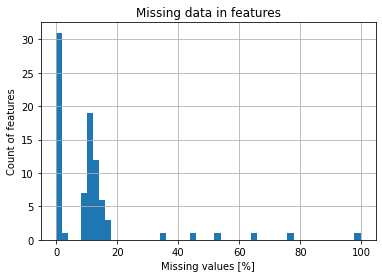

In [8]:
# Investigate patterns in the amount of missing data in each column.

# - Plot histogram of missing data in features
axes = nan_feat_percent.hist(bins=50)
axes.set_title("Missing data in features")
axes.set_xlabel("Missing values [%]")
axes.set_ylabel("Count of features")

> **Notes:** Around 35% of the features have no missing values. There is a cluster of features (around 60% of all features) that has 10-20% missing values. The six outlier features are clearly visible in the plot.

> **Notes:** I will set the threshold value for outliers as 34%, but the number could be 20% as well for the same result.

In [9]:
# Setting a threshold value for outlier features based on plot above (in percentage)
nan_feat_percent_threshold = 34

nan_feat_outliers = nan_feat_percent[nan_feat_percent > nan_feat_percent_threshold]
nan_feat_remaining = nan_feat_percent[nan_feat_percent <= nan_feat_percent_threshold]

print('Considered as outlier features:')
for item in nan_feat_outliers.index:
    print(item)

Considered as outlier features:
TITEL_KZ
AGER_TYP
KK_KUNDENTYP
KBA05_BAUMAX
GEBURTSJAHR
ALTER_HH


Text(0.5, 1.0, 'Missing values in dataset (colored white)')

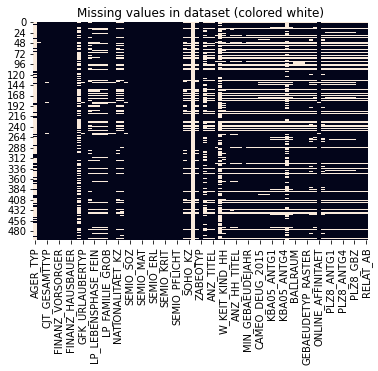

In [10]:
# Plotting missing values (heatmap) for the first 500 rows

# - Source: https://dev.to/tomoyukiaota/visualizing-the-patterns-of-missing-value-occurrence-with-python-46dj

sns.heatmap(azdias_pre1.iloc[0:500,:].isnull(), cbar=False) \
            .set_title("Missing values in dataset (colored white)")

> **Notes:** The heatmap is an example of the first 500 rows but illustrates the trend whole dataset. One can see the same six vertical (features) white bands that are marked as the outlier features. One can also notice there are many horizontal (row) white bands that are present in the last half of features, and in the middle of the first half of features.

Text(0.5, 1.0, 'Absolute correlation values for all columns')

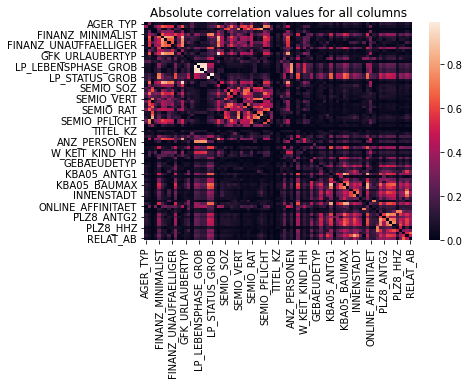

In [11]:
# Plotting absolute correlation coefficient for all columns
correlations = azdias_pre1.corr()
correlations[correlations == 1] = 0 # Set self-correlations to zero

sns.heatmap(correlations.abs()).set_title("Absolute correlation values for all columns")

> **Notes:** The above plot shows the absolute correlation coefficients. There are some regions that have more correlated data (red/white). Next, I will focus on the top-left section where you can see some highly correlated data.

> **Notes:** I also tried to make a comparison plot where the missing values would have been filled. But filling missing values with column means was slow with the dataset and the imputer would have required more preprocessing steps.

In [12]:
# Listing highly correlated pairs (>0.9) for all columns
# - Source: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

corr_cols  = correlations.unstack()
print('Highly correlated pairs:')
display(corr_cols[corr_cols > 0.9])

Highly correlated pairs:


GEBURTSJAHR            PRAEGENDE_JUGENDJAHRE    0.942798
LP_LEBENSPHASE_FEIN    LP_LEBENSPHASE_GROB      0.990153
                       LP_FAMILIE_FEIN          0.932188
                       LP_FAMILIE_GROB          0.953949
LP_LEBENSPHASE_GROB    LP_LEBENSPHASE_FEIN      0.990153
                       LP_FAMILIE_FEIN          0.959766
                       LP_FAMILIE_GROB          0.971096
LP_FAMILIE_FEIN        LP_LEBENSPHASE_FEIN      0.932188
                       LP_LEBENSPHASE_GROB      0.959766
                       LP_FAMILIE_GROB          0.988211
LP_FAMILIE_GROB        LP_LEBENSPHASE_FEIN      0.953949
                       LP_LEBENSPHASE_GROB      0.971096
                       LP_FAMILIE_FEIN          0.988211
LP_STATUS_FEIN         LP_STATUS_GROB           0.982411
LP_STATUS_GROB         LP_STATUS_FEIN           0.982411
PRAEGENDE_JUGENDJAHRE  GEBURTSJAHR              0.942798
dtype: float64

- Correlation between LP_LEBENSPHASE_FEIN/GROB features: 99.02%
- Correlation between LP_FAMILIE_FEIN/GROB features: 98.82%
- Correlation between LP_STATUS_FEIN/GROB features: 98.24%


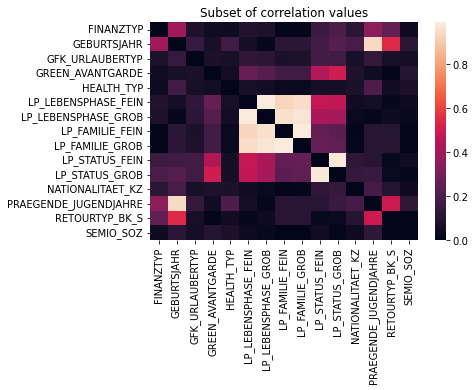

In [13]:
# Plotting correlation coefficients for a subset of highly correlated values 
sns.heatmap(correlations.abs().iloc[10:25,10:25]).set_title("Subset of correlation values")

# Checking correlations between fine/rough-scale features:
corr = correlations['LP_LEBENSPHASE_FEIN']['LP_LEBENSPHASE_GROB']
print('- Correlation between LP_LEBENSPHASE_FEIN/GROB features: {:.2f}%'.format(100 * corr))
corr = correlations['LP_FAMILIE_FEIN']['LP_FAMILIE_GROB']
print('- Correlation between LP_FAMILIE_FEIN/GROB features: {:.2f}%'.format(100 * corr))
corr = correlations['LP_STATUS_FEIN']['LP_STATUS_GROB']
print('- Correlation between LP_STATUS_FEIN/GROB features: {:.2f}%'.format(100 * corr))

> **Notes:** PRAEGENDE_JUGENDJAHRE and GEBURTSJAHR are strongly correlated (age-related features). But GEBURTSJAHR has many missing values and will be deleted as an outlier. Mixed type PRAEGENDE_JUGENDJAHRE has an age component and will be processed later.

> **Notes:** The three fine/rough-scale features (FEIN/GROB) have potentially overlapping data as they measure the same feature at a different level. LP_LEBENSPHASE_FEIN/GROB will be deleted later as mixed value, but later we should notice they may measure same the quantities.

In [14]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# - Removing outliers (features with more than threshold value)
azdias_pre2 = azdias_pre1.drop(columns=nan_feat_outliers.index.tolist())

print('Removed outlier features (values in %):')
print(nan_feat_outliers.to_string())

Removed outlier features (values in %):
TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699


#### Discussion 1.1.2: Assess Missing Data in Each Column

Around 35% of the features have no missing values. The majority of the features (around 60%) are in a cluster that has 10–20% missing values. Six features are were marked as outliers and removed from data. The removed features are (over 34% missing data): TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, and ALTER_HH.

The missing values in rows are concentrated in the last half of the features. The first half of features seem to have fewer missing values, excluding the middle section. The missing data is on random rows but on specific features as described above. And if a row has missing values, there are usually many, often consecutive, missing values on the same row.

In the demographics data, there are some feature pairs/groups that are highly correlated. PRAEGENDE_JUGENDJAHRE and GEBURTSJAHR were strongly correlated (age-related features), but the GEBURTSJAHR feature was deleted as an outlier. The remaining mixed type PRAEGENDE_JUGENDJAHRE has an age component and will be engineered later.
There are three fine/rough-scale features (FEIN/GROB) that have potentially overlapping data as they measure the same feature at a different level. LP_LEBENSPHASE_FEIN/GROB will be deleted later as mixed value. The remaining features LP_FAMILIE_FEIN/GROB and LP_STATUS_FEIN/GROB need focus.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0, 0.5, 'Count of rows')

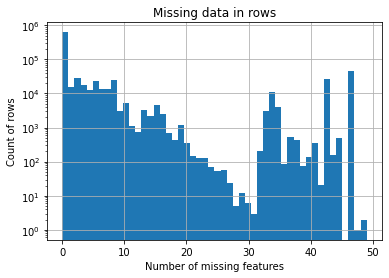

In [15]:
# How much data is missing in each row of the dataset?

# - Calculate NaNs in each row
nan_in_rows = azdias_pre2.isnull().sum(axis=1)

# Plot histogram on missing data in rows (logarithm y)
nan_row_bins = nan_in_rows.max() - nan_in_rows.min() + 1 # match bins with missing values
axes = nan_in_rows.hist(bins=nan_row_bins, log=True)
axes.set_title("Missing data in rows")
axes.set_xlabel("Number of missing features")
axes.set_ylabel("Count of rows")

(0.0, 50000.0)

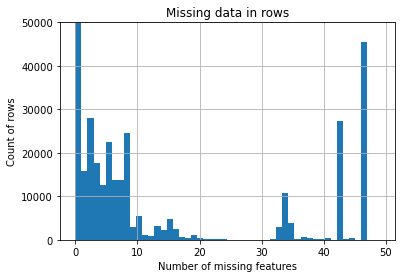

In [16]:
# Plot histogram on missing data in rows (linear y)
axes = nan_in_rows.hist(bins=nan_row_bins, log=False)
axes.set_title("Missing data in rows")
axes.set_xlabel("Number of missing features")
axes.set_ylabel("Count of rows")
axes.set_ylim(0, 50000)

> **Notes:** I used both logarithmic and linear scales on the y-axis to better understand the patterns in missing values.

> **Notes:** In the linear plot, one can see a cluster between 0-8 missing features that could be used as one split criterion. On the other hand, there is a region of fewer row counts at values between 9 and 32. The linear plot identifies rows that miss more than 32 features as outliers (as in the case of features). Thus, I decided to split the data using 32 missing features as the threshold value.

In [17]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Dividing data into two subsets based on threshold value
nan_row_threshold = 32

# Select rows with NaNs over threshold value
nan_rows_insufficient = nan_in_rows[nan_in_rows > nan_row_threshold]
azdias_rows_insufficient = azdias_pre2.iloc[nan_rows_insufficient.index.tolist()]

# Select rows with NaNs equal or under threshold value
nan_rows_sufficient = nan_in_rows[nan_in_rows <= nan_row_threshold]
azdias_rows_sufficient = azdias_pre2.iloc[nan_rows_sufficient.index.tolist()]

In [18]:
print(f'Missing values on rows compared to the threshold value (={nan_row_threshold}):')
print('- Equal or below the threshold value: {:.2f}%'.format(100 * azdias_rows_sufficient.shape[0] \
                                              / azdias_pre2.shape[0]))
print('- Above the threshold value: {:.2f}%'.format(100 * azdias_rows_insufficient.shape[0] \
                                              / azdias_pre2.shape[0]))

Missing values on rows compared to the threshold value (=32):
- Equal or below the threshold value: 89.57%
- Above the threshold value: 10.43%


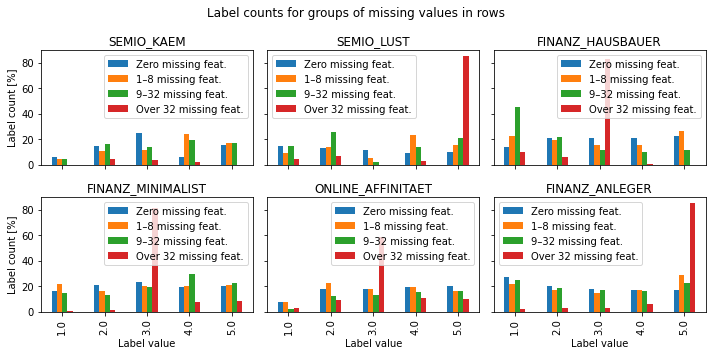

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# List columns with no or few missing values (first 30 are good), and randomize 6 features
nan_feat_percent = nan_feat_percent.sort_values(axis=0, ascending=True)
random_list = random.sample(nan_feat_percent[:30].index.tolist(), 6)

# Source: https://stackoverflow.com/questions/22483588/how-can-i-plot-separate-pandas-dataframes-as-subplots
# Source: https://stackoverflow.com/questions/6963035/pyplot-axes-labels-for-subplots

# Dividing rows into 4 groups based on missing values

# - No missing values
nan_rows_1 = nan_in_rows[nan_in_rows == 0]
azdias_rows_1 = azdias_pre2.iloc[nan_rows_1.index.tolist()]

# - 1-8 missing values
nan_rows_2 = nan_in_rows[nan_in_rows.between(1, 8)]
azdias_rows_2 = azdias_pre2.iloc[nan_rows_2.index.tolist()]

# - 9-32 missing values
nan_rows_3 = nan_in_rows[nan_in_rows.between(9, 32)]
azdias_rows_3 = azdias_pre2.iloc[nan_rows_3.index.tolist()]

# - More than 32 missing values
nan_rows_4 = nan_in_rows[nan_in_rows > 32]
azdias_rows_4 = azdias_pre2.iloc[nan_rows_4.index.tolist()]

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(10,5))
plot_number = 1

for cols in range(3):
    for rows in range(2):
        # Column name from random list
        column_name = random_list[plot_number-1]
        
        # Calculate label percentages for low-NaN rows
        column_1 = 100 * azdias_rows_1[column_name].value_counts() \
                            .sort_index() / azdias_rows_1.shape[0]
        column_1.rename('Zero missing feat.', inplace=True)

        # Calculate label percentages for low-NaN rows
        column_2 = 100 * azdias_rows_2[column_name].value_counts() \
                            .sort_index() / azdias_rows_2.shape[0]
        column_2.rename('1–8 missing feat.', inplace=True)

        # Calculate label percentages for low-NaN rows
        column_3 = 100 * azdias_rows_3[column_name].value_counts() \
                            .sort_index() / azdias_rows_3.shape[0]
        column_3.rename('9–32 missing feat.', inplace=True)

        # Calculate label percentages for low-NaN rows
        column_4 = 100 * azdias_rows_4[column_name].value_counts() \
                            .sort_index() / azdias_rows_4.shape[0]
        column_4.rename('Over 32 missing feat.', inplace=True)
        
        # Combine into dataframe
        column_compare = pd.concat([column_1, column_2, column_3, column_4], axis=1)

        # Subplot
        column_compare.plot(ax=axes[rows, cols], kind='bar')
        axes[rows, cols].set_title(column_name)
        plt.setp(axes, xlabel='Label value')
        plt.setp(axes, ylabel='Label count [%]')
        
        plot_number += 1

fig.suptitle('Label counts for groups of missing values in rows')
fig.tight_layout() # all texts visible

> **Notes:** The six plotted features are random have no missing values.

> **Notes:** I plotted four groups of missing values on rows to better justify the choice of the threshold value. Even there are some differences between groups 0, 1–8, and 9–32, the last group that has over 32 missing values on rows looks more different. Especially on non-binary features, the peak counts are concentrated on one label and the distribution also looks different.

In [20]:
# Removing rows with NaN more than the threshold value

print(f'Number of rows before cleanup: {azdias_pre2.shape[0]:,}')
azdias_pre3 = azdias_pre2.drop(index=nan_rows_insufficient.index.tolist(), axis=1)
print(f'Number of rows after cleanup: {azdias_pre3.shape[0]:,}')

Number of rows before cleanup: 891,221
Number of rows after cleanup: 798,276


#### Discussion 1.1.3: Assess Missing Data in Each Row

In the histogram plot, there is a cluster between 0–8 missing features on rows that could be used as one split criterion. I decided to include also a region of rows with fewer missing values between 9–32 (around 3% of all rows). Setting the threshold value at 32 missing features removed roughly 10% of rows at this stage.

I also compared two subsets, namely cleaned data and removed data, using plots of label distributions for six random features. The selected features had no missing values. The data of more than 32 missing values on rows looked qualitatively more different for most labels. Especially on non-binary features, the peak counts are concentrated on one label and the distribution also looks different.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?

# - Updating feat_info to match with cleaned dataframe
feat_info_updated = feat_info.query('attribute in ' + str(azdias_pre3.columns.tolist()))

print('List of data types:')
print(feat_info_updated["type"].value_counts().to_string())

List of data types:
ordinal        49
categorical    18
mixed           6
numeric         6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# List of categorical features from feat_info
categorical_features = feat_info_updated.query('type in [\'categorical\']') \
                       .loc[:,'attribute'].values.tolist()

# Print list of categories and types
print('Categorical features:\n')
print('{:16s} {:25s} {}'.format('Name', 'Type (+values)', 'First 3 labels'))

for feature in categorical_features:
    value_list = azdias_pre3[feature].value_counts().sort_index().index.tolist()

    # Define category type
    category_type = None
    if len(value_list) <= 2:
        category_type = 'binary'
    else:
        category_type = 'multi-level'    

    # Define value type
    value_type = 'numeric'
    for item in value_list:
        try:
            item = int(item)
        except ValueError:
            value_type = 'non-numeric'
    category_type = category_type + f' ({value_type})'

    # Print row before value examples
    print('{:16s} {:25s}'.format(feature, category_type), end=' ')

    # Print value examples (first 3)
    for i in range(0, len(value_list)):
        if i == 2: # stop at 3
            print(value_list[i])
            break
        elif i < len(value_list)-1:
            print(value_list[i], end=', ')
        else:
            print(value_list[i])

Categorical features:

Name             Type (+values)            First 3 labels
ANREDE_KZ        binary (numeric)          1.0, 2.0
CJT_GESAMTTYP    multi-level (numeric)     1.0, 2.0, 3.0
FINANZTYP        multi-level (numeric)     1.0, 2.0, 3.0
GFK_URLAUBERTYP  multi-level (numeric)     1.0, 2.0, 3.0
GREEN_AVANTGARDE binary (numeric)          0, 1
LP_FAMILIE_FEIN  multi-level (numeric)     1.0, 2.0, 3.0
LP_FAMILIE_GROB  multi-level (numeric)     1.0, 2.0, 3.0
LP_STATUS_FEIN   multi-level (numeric)     1.0, 2.0, 3.0
LP_STATUS_GROB   multi-level (numeric)     1.0, 2.0, 3.0
NATIONALITAET_KZ multi-level (numeric)     1.0, 2.0, 3.0
SHOPPER_TYP      multi-level (numeric)     0.0, 1.0, 2.0
SOHO_KZ          binary (numeric)          0.0, 1.0
VERS_TYP         binary (numeric)          1.0, 2.0
ZABEOTYP         multi-level (numeric)     1.0, 2.0, 3.0
GEBAEUDETYP      multi-level (numeric)     1.0, 2.0, 3.0
OST_WEST_KZ      binary (non-numeric)      O, W
CAMEO_DEUG_2015  multi-level (numeric)  

> **Notes:** There are five binary features that are mostly good as they are. OST_WEST_KZ needs to be encoded manually to numerical values.

> **Notes:** The rest 13 are multi-level features. Earlier I found that LP_FAMILIE_FEIN/GROB and LP_STATUS_FEIN/GROB (fine/coarse) features are highly correlated and have similar data at different levels. I will delete the fine features since the coarse-scale features may provide more clear interpretation about different groups. The remaining nine features will be re-encoded using one-hot encoding.

In [23]:
# - Function to list multi-level categories
def multilevel_category_features(data, feat_info):
    """
    Finds multi-level categories in demographics data based 
    on "feat_info" content.

     Args:
        (dframe) data - demographics data rows and features
        (dframe) feat_info - feature names in "attribute" column 
        and types in "type" column
    Returns:
        (list) multilevel_categories - multi-level categories

    """
    
    multilevel_categories = []
    
    # List of categorical features from feat_info
    categorical_features = feat_info.query('type in [\'categorical\']') \
                           .loc[:,'attribute'].values.tolist()
    
    for feature in categorical_features:
        value_list = data[feature].value_counts().index.tolist()

        # One-hot encode all features more than 2 different labels
        if len(value_list) > 2:
            multilevel_categories.append(feature)   
            
    return multilevel_categories

In [24]:
# Find all multi-level categories for re-encoding
one_hot_encode_features = multilevel_category_features(azdias_pre3, feat_info_updated)

print('Features to be one-hot encoded:')
for item in one_hot_encode_features:
    print(item)

Features to be one-hot encoded:
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
ZABEOTYP
GEBAEUDETYP
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Make first a copy
azdias_pre4 = azdias_pre3.copy()

# - Convert non-numeric binary feature to numeric values:
azdias_pre4['OST_WEST_KZ'].replace(['W', 'O'],[1, 0], inplace=True) 
azdias_pre4.rename(columns={'OST_WEST_KZ': 'OST_WEST_KZ_W'}, inplace=True)
print(f'Number of features before removing features: {azdias_pre4.shape[1]}')

# Removing LP_STATUS_FEIN and LP_FAMILIE_FEIN fine-scale features:
azdias_pre4.drop(['LP_STATUS_FEIN', 'LP_FAMILIE_FEIN'], axis=1, inplace=True)
one_hot_encode_features.remove('LP_STATUS_FEIN')
one_hot_encode_features.remove('LP_FAMILIE_FEIN')

# - One-hot encode:
print(f'Number of features before one-hot encoding: {azdias_pre4.shape[1]}')
azdias_pre4 = pd.get_dummies(azdias_pre4, columns=one_hot_encode_features)
print(f'Number of features after one-hot encoding: {azdias_pre4.shape[1]}')

Number of features before removing features: 79
Number of features before one-hot encoding: 77
Number of features after one-hot encoding: 173


#### Discussion 1.2.1: Re-Encode Categorical Features

There were five categorical binary features that were mostly good as they were. The numeric features ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, and VERS_TYP didn't need action. The non-numeric feature OST_WEST_KZ (O, W) was converted to numerical values as OST_WEST_KZ_W (0, 1).

The rest 13 were multi-level features. Earlier I found that LP_FAMILIE_FEIN/GROB and LP_STATUS_FEIN/GROB (fine/coarse) features were highly correlated and had similar data at different levels. I deleted the fine features since the coarse features may provide more clear interpretation about different groups. The remaining nine features (CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, NATIONALITAET_KZ, SHOPPER_TYP, ZABEOTYP, GEBAEUDETYP, CAMEO_DEUG_2015, and CAMEO_DEU_2015) were re-encoded using one-hot encoding.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# List of categorical features
mixed_features = feat_info_updated.query('type in [\'mixed\']') \
                 .loc[:,'attribute'].values.tolist()

print('List of mixed features:')
for feature in mixed_features:
    print(feature)
    #print(azdias[feature].value_counts().sort_index())

List of mixed features:
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
WOHNLAGE
CAMEO_INTL_2015
PLZ8_BAUMAX


In [27]:
# Making a copy before changes
azdias_pre5 = azdias_pre4.copy()

> **Notes:** Two mixed features LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB provide information about age, income and household type. However, some labels miss one or several indicators so I shouldn't split this data. And looks like similar information can be found in other features (including mixed PRAEGENDE_JUGENDJAHRE). So it's best to remove them.

In [28]:
# Removing incomplete/overlapping mixed features LP_LEBENSPHASE_FEIN/GROB
azdias_pre5.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1, inplace=True)

> **Notes:** Mixed feature WOHNLAGE provides mostly information about the neighborhood quality, but it also has a rural flag on two labels. The rural flag doesn't indicate whether the neighborhood is good or bad, and cannot be treated as insignificant (23% of all values) to be treated as missing values. I will remove WOHNLAGE since BALLRAUM, EWDICHTE and INNENSTADT provide similar information rurality of the neighborhood. Unfortunately, there isn't as good information about the neighborhood quality, but we have some information at the household level.

In [29]:
print('Values in WOHNLAGE feature:')
print(azdias_pre5['WOHNLAGE'].value_counts(dropna=False).sort_index().to_string())

rural_percentage = 100 * ((azdias_pre5['WOHNLAGE'])>=7).sum() / azdias_pre5.shape[0]
print(f'\nFlagged as rural label: {rural_percentage:.2f}%')

# Removing WOHNLAGE feature
azdias_pre5.drop(['WOHNLAGE'], axis=1, inplace=True)

Values in WOHNLAGE feature:
0.0      6948
1.0     43918
2.0    100376
3.0    249719
4.0    135973
5.0     74346
7.0    169318
8.0     17473
NaN       205

Flagged as rural label: 23.40%


> **Notes:** Mixed feature PLZ8_BAUMAX provides information about the most common building type (family/business). Each label about family home sizes is covered in its separate feature PLZ8_ANTG1-4. However, one label, roughly 13% of values, is different from others (5, mainly business buildings). That is why I will convert the feature to binary (mainly family homes or not).

In [30]:
# Print original feature and calculate percentage of rural values
print('Values in original PLZ8_BAUMAX feature:')
print(azdias_pre5['PLZ8_BAUMAX'].value_counts(dropna=False).sort_index().to_string())

rural_percentage = 100 * ((azdias_pre5['PLZ8_BAUMAX']) == 5).sum() / azdias_pre5.shape[0]
print(f'\nValues flagged as mainly business buildings: {rural_percentage:.2f}%')

# Rename and remap values to indicate if mainly family homes or not
azdias_pre5.rename(columns={'PLZ8_BAUMAX': 'PLZ8_BAUMAX_MAINLY_FAMILYHOMES'}, inplace=True)
input_list = [1, 2, 3, 4, 5]
output_list = [1, 1, 1, 1, 0]
azdias_pre5['PLZ8_BAUMAX_MAINLY_FAMILYHOMES'].replace(input_list, output_list, inplace=True)

# Print new feature
print('\nValues in new PLZ8_BAUMAX_MAINLY_FAMILYHOMES feature:')
print(azdias_pre5['PLZ8_BAUMAX_MAINLY_FAMILYHOMES'].value_counts(dropna=False).sort_index().to_string())

Values in original PLZ8_BAUMAX feature:
1.0    499550
2.0     70407
3.0     50732
4.0     56684
5.0     97333
NaN     23570

Values flagged as mainly business buildings: 12.19%

Values in new PLZ8_BAUMAX_MAINLY_FAMILYHOMES feature:
0.0     97333
1.0    677373
NaN     23570


In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

> **Notes** Splitting the mixed feature PRAEGENDE_JUGENDJAHRE into two ordinal features "decade" and "movement" based on the information in Data_Dictionary.md. West (W) and East (E) Germany division isn't taken into account since data looks incomplete in that sense (some entries have only joint data E+W).

In [32]:
# Print original PRAEGENDE_JUGENDJAHRE feature
print('Values in original PRAEGENDE_JUGENDJAHRE feature:')
print(azdias_pre5['PRAEGENDE_JUGENDJAHRE'].value_counts(dropna=False).sort_index().to_string())

# Add a decade feature (40s=1, 50s=2, 60s=3, 70s=4, 80s=5, 90s=6)
azdias_pre5['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_pre5['PRAEGENDE_JUGENDJAHRE']
input_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
output_list = [1,1,2,2,3,3,3,4,4, 5,5,5,5,6,6]
azdias_pre5['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(input_list, output_list, inplace=True)

print('\nValues in new PRAEGENDE_JUGENDJAHRE_DECADE feature:')
print(azdias_pre5['PRAEGENDE_JUGENDJAHRE_DECADE'].value_counts(dropna=False).sort_index().to_string())

# Add a movement feature (mainstream = 0, avantgarde = 1)
azdias_pre5['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_pre5['PRAEGENDE_JUGENDJAHRE']
input_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
output_list = [0,1,0,1,0,1,1,0,1,0,1,0,1,0,1]
azdias_pre5['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(input_list, output_list, inplace=True)

print('\nValues in new PRAEGENDE_JUGENDJAHRE_MOVEMENT feature:')
print(azdias_pre5['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].value_counts(dropna=False).sort_index().to_string())

# Delete original feature
azdias_pre5.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)

Values in original PRAEGENDE_JUGENDJAHRE feature:
1.0      20679
2.0       7479
3.0      53852
4.0      20451
5.0      84699
6.0      25652
7.0       4010
8.0     141640
9.0      33570
10.0     85808
11.0     35752
12.0     24446
13.0      5764
14.0    183165
15.0     42547
NaN      28762

Values in new PRAEGENDE_JUGENDJAHRE_DECADE feature:
1.0     28158
2.0     74303
3.0    114361
4.0    175210
5.0    151770
6.0    225712
NaN     28762

Values in new PRAEGENDE_JUGENDJAHRE_MOVEMENT feature:
0.0    594289
1.0    175225
NaN     28762


In [33]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

> **Notes:** Splitting the mixed feature CAMEO_INTL_201 into two ordinal features "wealth" and "life stage" based on the information in Data_Dictionary.md. The division can be made using the digit position.

In [34]:
# Print original CAMEO_INTL_2015 feature
print('Values in original CAMEO_INTL_2015 feature:')
print(azdias_pre5['CAMEO_INTL_2015'].value_counts(dropna=False).sort_index().to_string())

# Splitting based on digit position
# - Adapted from source: https://stackoverflow.com/questions/60229544/remove-last-char-in-a-string-for-each-row-in-pandas-df
# - skipna option removed from "astype" method so using "fillna" method with empty value as a placement value 

# Add wealth feature (first digit)
azdias_pre5['CAMEO_INTL_2015_WEALTH'] = azdias_pre5['CAMEO_INTL_2015']
azdias_pre5['CAMEO_INTL_2015_WEALTH'] = azdias_pre5['CAMEO_INTL_2015_WEALTH'] \
                                        .fillna('').astype(str).str[:-1]
azdias_pre5.loc[azdias_pre5['CAMEO_INTL_2015_WEALTH'] == '', 'CAMEO_INTL_2015_WEALTH'] = None

print('\nValues in new CAMEO_INTL_2015_WEALTH feature:')
print(azdias_pre5['CAMEO_INTL_2015_WEALTH'].value_counts(dropna=False).sort_index().to_string())

# Add lifestage feature (last digit)
azdias_pre5['CAMEO_INTL_2015_LIFESTAGE'] = azdias_pre5['CAMEO_INTL_2015']
azdias_pre5['CAMEO_INTL_2015_LIFESTAGE'] = azdias_pre5['CAMEO_INTL_2015_LIFESTAGE'] \
                                           .fillna('').astype(str).str[1:]
azdias_pre5.loc[azdias_pre5['CAMEO_INTL_2015_LIFESTAGE'] == '', 'CAMEO_INTL_2015_LIFESTAGE'] = None

print('\nValues in new CAMEO_INTL_2015_LIFESTAGE feature:')
print(azdias_pre5['CAMEO_INTL_2015_LIFESTAGE'].value_counts(dropna=False).sort_index().to_string())

# Delete original feature
azdias_pre5.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)

Values in original CAMEO_INTL_2015 feature:
12      13249
13      26336
14      62884
15      16974
22      33155
23      26750
24      91158
25      39628
31      19024
32      10354
33       9935
34      18524
35      10356
41      92336
43      56672
44      14820
45      26132
51     133694
52      20542
54      45391
55      23955
NaN      6407

Values in new CAMEO_INTL_2015_WEALTH feature:
1      119443
2      190691
3       68193
4      189960
5      223582
NaN      6407

Values in new CAMEO_INTL_2015_LIFESTAGE feature:
1      245054
2       77300
3      119693
4      232777
5      117045
NaN      6407


#### Discussion 1.2.2: Engineer Mixed-Type Features

**LP_LEBENSPHASE_FEIN/GROB**

The features LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB provided mixed information about age, income and household type. I decided to remove both features since some labels miss one or several indicators of the three measures.

**WOHNLAGE**

The feature provided mostly information about the neighborhood quality, but it has also a rural flag on two labels. The rural flag doesn't indicate whether the neighborhood is good or bad, and cannot be treated as insignificant (23% of all values) to be disregarded as missing values. I decided to remove the feature even though there wasn't a similar feature measuring the neighborhood quality.

**PLZ8_BAUMAX**

The feature provided information about the most common building type (_family/business_). Each label about family home sizes is covered in its separate feature PLZ8_ANTG1-4. However, one label, roughly 13% of values, is different from others (_mainly business buildings_). I converted the feature to a binary type PLZ8_BAUMAX_MAINLY_FAMILYHOMES (0, 1).

**PRAEGENDE_JUGENDJAHRE**

The feature provided information about dominating movement of a person's youth. I splitted the mixed data into two ordinal features PRAEGENDE_JUGENDJAHRE_DECADE (decade) and PRAEGENDE_JUGENDJAHRE_MOVEMENT (movement). I also combined separate West (W) and East (E) Germany labels since some labels had only joint data E+W.

**CAMEO_INTL_2015**

The feature provided information about wealth and life stages. I split the mixed data into two ordinal features CAMEO_INTL_2015_WEALTH (wealth) and CAMEO_INTL_2015_LIFESTAGE (life stage).

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [35]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

Number of features: 172
Number of rows: 798,276


Text(0.5, 1.0, 'Missing values in cleaned data')

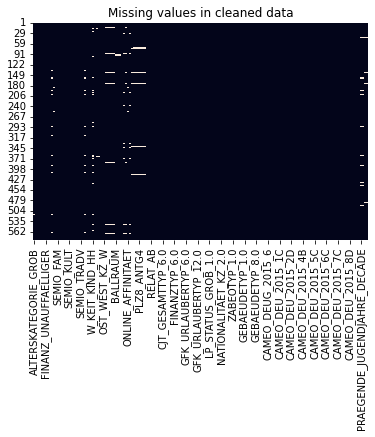

In [36]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Making a copy for cleaned data
azdias_cleaned = azdias_pre5.copy()

# Checking data size
print(f'Number of features: {azdias_cleaned.shape[1]}')
print(f'Number of rows: {azdias_cleaned.shape[0]:,}')

# Replotting missing values (heatmap) for first 500 rows
sns.heatmap(azdias_cleaned.iloc[0:500,:].isnull(), cbar=False).set_title("Missing values in cleaned data")

In [37]:
# Listing all labels in features (checking content so that all labels numeric etc.)
for feature_name in azdias_cleaned.columns:

    print(f'{feature_name}: ', end=(''))
    feature_content = azdias_cleaned[feature_name].value_counts(dropna=False).sort_index()
    
    for index in range(len(feature_content)):
        if index != len(feature_content) - 1:
            print(feature_content.index[index], end=', ')
        else:
            print(feature_content.index[index])

ALTERSKATEGORIE_GROB: 1.0, 2.0, 3.0, 4.0, nan
ANREDE_KZ: 1.0, 2.0
FINANZ_MINIMALIST: 1.0, 2.0, 3.0, 4.0, 5.0
FINANZ_SPARER: 1.0, 2.0, 3.0, 4.0, 5.0
FINANZ_VORSORGER: 1.0, 2.0, 3.0, 4.0, 5.0
FINANZ_ANLEGER: 1.0, 2.0, 3.0, 4.0, 5.0
FINANZ_UNAUFFAELLIGER: 1.0, 2.0, 3.0, 4.0, 5.0
FINANZ_HAUSBAUER: 1.0, 2.0, 3.0, 4.0, 5.0
GREEN_AVANTGARDE: 0, 1
HEALTH_TYP: 1.0, 2.0, 3.0, nan
RETOURTYP_BK_S: 1.0, 2.0, 3.0, 4.0, 5.0, nan
SEMIO_SOZ: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_FAM: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_REL: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_MAT: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_VERT: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_LUST: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_ERL: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_KULT: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_RAT: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_KRIT: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_DOM: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_KAEM: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0
SEMIO_PFLICHT: 1.0, 2.0, 3.0, 4.0, 5.

PLZ8_ANTG1: 0.0, 1.0, 2.0, 3.0, 4.0, nan
PLZ8_ANTG2: 0.0, 1.0, 2.0, 3.0, 4.0, nan
PLZ8_ANTG3: 0.0, 1.0, 2.0, 3.0, nan
PLZ8_ANTG4: 0.0, 1.0, 2.0, nan
PLZ8_BAUMAX_MAINLY_FAMILYHOMES: 0.0, 1.0, nan
PLZ8_HHZ: 1.0, 2.0, 3.0, 4.0, 5.0, nan
PLZ8_GBZ: 1.0, 2.0, 3.0, 4.0, 5.0, nan
ARBEIT: 1.0, 2.0, 3.0, 4.0, 5.0, nan
ORTSGR_KLS9: 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan
RELAT_AB: 1.0, 2.0, 3.0, 4.0, 5.0, nan
CJT_GESAMTTYP_1.0: 0, 1
CJT_GESAMTTYP_2.0: 0, 1
CJT_GESAMTTYP_3.0: 0, 1
CJT_GESAMTTYP_4.0: 0, 1
CJT_GESAMTTYP_5.0: 0, 1
CJT_GESAMTTYP_6.0: 0, 1
FINANZTYP_1.0: 0, 1
FINANZTYP_2.0: 0, 1
FINANZTYP_3.0: 0, 1
FINANZTYP_4.0: 0, 1
FINANZTYP_5.0: 0, 1
FINANZTYP_6.0: 0, 1
GFK_URLAUBERTYP_1.0: 0, 1
GFK_URLAUBERTYP_2.0: 0, 1
GFK_URLAUBERTYP_3.0: 0, 1
GFK_URLAUBERTYP_4.0: 0, 1
GFK_URLAUBERTYP_5.0: 0, 1
GFK_URLAUBERTYP_6.0: 0, 1
GFK_URLAUBERTYP_7.0: 0, 1
GFK_URLAUBERTYP_8.0: 0, 1
GFK_URLAUBERTYP_9.0: 0, 1
GFK_URLAUBERTYP_10.0: 0, 1
GFK_URLAUBERTYP_11.0: 0, 1
GFK_URLAUBERTYP_12.0: 0, 1
LP_FAMILIE

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [38]:
def clean_data(df, feat_info, feat_nan_percent_thres, row_nan_thres, row_nan_inclusion='low'):
    """
    Cleans demograpnics data by converting missing values, removing 
    missing data based on given threshold values, and does some 
    re-encoding and engineering.

    Args:
        (dframe) df - demographics data
        (dframe) feat_info - feature names, types and missing data list
        (float) feat_nan_percent_thres - percentage threshold value for
        columns. Features that have more missing values than 
        "feat_nan_percent_thres" are removed from the data
        (int) row_nan_thres - threshold value for rows. Rows that have 
        less or more missing values than "row_nan_thres" are removed 
        based on given condition
        (str) row_nan_inclusion - "low" = rows with low number of 
        missing values are retained, "high" = rows with high number of 
        missing values retained, "all" = all rows retained 
    Returns:
        (dframe) df_cleaned - cleaned dataframe

    """
    
    # Print shape
    
    print('Input demographics data:')
    print('- Number of features: {}'.format(df.shape[1]))
    print('- Number of rows: {:,}'.format(df.shape[0]))

    print('\nProcess:')
    
    # Convert missing values into NaNs

    df_pre1 = convert_missing_values(df, feat_info)
    print('- Converted missing values to empty values (NaN)')
    
    # Remove features

    nan_feat_percent = (100 * df_pre1.isnull().sum() / df_pre1.shape[0])
    nan_feat_outliers = nan_feat_percent[nan_feat_percent > feat_nan_percent_thres]

    df_pre2 = df_pre1.drop(columns=nan_feat_outliers.index.tolist())
    
    print('- Removed {} features having over {:.2f}% missing values:' \
          .format(len(nan_feat_outliers), feat_nan_percent_thres))

    # Remove rows

    # - Making a copy
    df_pre3 = df_pre2.copy()
    
    # - Calculate NaNs in rows
    nan_in_rows = df_pre2.isnull().sum(axis=1)

    # - Three options to remove rows with NaNs
    if row_nan_inclusion == 'low':
        drop_rows = nan_in_rows[nan_in_rows > nan_row_threshold]
        df_pre3 = df_pre3.drop(index=drop_rows.index.tolist(), axis=1)

        print('- Removed {:,} rows having more than {} missing values' \
              .format(df_pre2.shape[0] - df_pre3.shape[0], row_nan_thres))
        
    elif row_nan_inclusion == 'high':
        drop_rows = nan_in_rows[nan_in_rows <= nan_row_threshold]
        df_pre3 = df_pre3.drop(index=drop_rows.index.tolist(), axis=1)

        print('- Removed {:,} rows having equal or less than {} missing values' \
              .format(df_pre2.shape[0] - df_pre3.shape[0], row_nan_thres))
        
    elif row_nan_inclusion == 'all':
        print('- No rows removed in data')
    
    else:  
        print('- NOTE: Unknown option \'{row_nan_inclusion}\'. No rows removed in data.')
    
    # Re-encode features
    
    # - Making a copy
    df_pre4 = df_pre3.copy()
    
    # - Updating feat_info to match with cleaned dataframe
    feat_info_updated = feat_info.query('attribute in ' + str(df_pre4.columns.tolist()))

    # - Find all multi-level categories for one-hot encoding
    one_hot_encode_features = multilevel_category_features(df_pre4, feat_info_updated)

    # - Convert non-numeric binary feature:
    df_pre4['OST_WEST_KZ'].replace(['W', 'O'],[1, 0], inplace=True)
    df_pre4.rename(columns={'OST_WEST_KZ': 'OST_WEST_KZ_W'}, inplace=True)
    print('- Converted non-numeric binary features to numeric')
    
    # - Removing LP_STATUS_FEIN and LP_FAMILIE_FEIN fine-scale features:
    df_pre4.drop(['LP_STATUS_FEIN', 'LP_FAMILIE_FEIN'], axis=1, inplace=True)
    one_hot_encode_features.remove('LP_STATUS_FEIN')
    one_hot_encode_features.remove('LP_FAMILIE_FEIN')

    # - Re-encoding using one-hot encoding
    df_pre4 = pd.get_dummies(df_pre4, columns=one_hot_encode_features)
    print('- Added one-hot encoding to multi-level category features')
    
    # Engineer mix-type features

    # - Removing incomplete/overlapping mixed features LP_LEBENSPHASE_FEIN/GROB
    df_pre5 = df_pre4.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'], axis=1)
        
    # - Removing WOHNLAGE feature
    df_pre5.drop(['WOHNLAGE'], axis=1, inplace=True)
    
    # - Engineer PLZ8_BAUMAX feature
    df_pre5.rename(columns={'PLZ8_BAUMAX': 'PLZ8_BAUMAX_MAINLY_FAMILYHOMES'}, inplace=True)
    input_list = [1, 2, 3, 4, 5]
    output_list = [1, 1, 1, 1, 0]
    df_pre5['PLZ8_BAUMAX_MAINLY_FAMILYHOMES'].replace(input_list, output_list, inplace=True)

    # - Engineer PRAEGENDE_JUGENDJAHRE
    #   * Add a decade feature (40s=1, 50s=2, 60s=3, 70s=4, 80s=5, 90s=6)
    df_pre5['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_pre5['PRAEGENDE_JUGENDJAHRE']
    input_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    output_list = [1,1,2,2,3,3,3,4,4, 5,5,5,5,6,6]
    df_pre5['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(input_list, output_list, inplace=True)
    #   * Add a movement feature (mainstream = 0, avantgarde = 1)
    df_pre5['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_pre5['PRAEGENDE_JUGENDJAHRE']
    input_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    output_list = [0,1,0,1,0,1,1,0,1,0,1,0,1,0,1]
    df_pre5['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].replace(input_list, output_list, inplace=True)
    #   * Delete original feature
    df_pre5.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    
    # - Engineer CAMEO_INTL_2015 feature
    #   * Add wealth feature (first digit)
    df_pre5['CAMEO_INTL_2015_WEALTH'] = df_pre5['CAMEO_INTL_2015']
    df_pre5['CAMEO_INTL_2015_WEALTH'] = df_pre5['CAMEO_INTL_2015_WEALTH'] \
                                        .fillna('').astype(str).str[:-1]
    df_pre5.loc[df_pre5['CAMEO_INTL_2015_WEALTH'] == '', 'CAMEO_INTL_2015_WEALTH'] = None

    #   * Add lifestage feature (last digit)
    df_pre5['CAMEO_INTL_2015_LIFESTAGE'] = df_pre5['CAMEO_INTL_2015']
    df_pre5['CAMEO_INTL_2015_LIFESTAGE'] = df_pre5['CAMEO_INTL_2015_LIFESTAGE'] \
                                           .fillna('').astype(str).str[1:]
    df_pre5.loc[df_pre5['CAMEO_INTL_2015_LIFESTAGE'] == '', 'CAMEO_INTL_2015_LIFESTAGE'] = None

    #   * Delete original feature
    df_cleaned = df_pre5.drop(['CAMEO_INTL_2015'], axis=1)
    
    print('- Removed/engineered mix-type features')
    
    print('\nOutput demographics data:')
    print('- Number of features: {}'.format(df_cleaned.shape[1]))
    print('- Number of rows: {:,}'.format(df_cleaned.shape[0]))
    
    # Return the cleaned dataframe.
    return df_cleaned

In [39]:
# Verifying that content in cleaned dataframe is the same as function output
print('\nFunction output matches with cleaned general demographics data: {}' \
      .format(azdias_cleaned.equals(clean_data(azdias, feat_info, 34, 32))))

Input demographics data:
- Number of features: 85
- Number of rows: 891,221

Process:
- Converted missing values to empty values (NaN)
- Removed 6 features having over 34.00% missing values:
- Removed 92,945 rows having more than 32 missing values
- Converted non-numeric binary features to numeric
- Added one-hot encoding to multi-level category features
- Removed/engineered mix-type features

Output demographics data:
- Number of features: 172
- Number of rows: 798,276

Function output matches with cleaned general demographics data: True


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [40]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

In [41]:
# Apply feature scaling to the general population demographics data.

print(f'Missing values before imputer: {azdias_cleaned.isnull().sum().sum():,}')
imp = SimpleImputer(strategy='mean') # Replace with "Imputer" in old sklean version
azdias_imp = imp.fit_transform(azdias_cleaned)
print(f'Missing values after imputer: {np.isnan(azdias_imp).sum().sum()}')

scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imp)

Missing values before imputer: 792,783
Missing values after imputer: 0


### Discussion 2.1: Apply Feature Scaling

I used the simple imputer model to replace missing values with the mean of the feature. This may have some drawbacks since imputation with mean values "moves" data towards the average and decreases variance.

For feature scaling I used StandardScaler and it would make sense for most data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [42]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

In [43]:
# Plot explained variance ratio

# - Defining a function for plotting
def plot_explained_var_ratio(pca):
    """
    Plots explained variance ratio versus PCA principal components
    
    Args:
        (pca) pca - PCA object
    """
    
    pca_explained_var_ratio = pca.explained_variance_ratio_

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(5,5))

    fig.suptitle('Explained Variance vs. Principal Component')
    axes[0].plot(range(len(pca_explained_var_ratio)), 100 * pca_explained_var_ratio)
    axes[0].set(ylabel='Variance explained [%]')

    axes[1].plot(range(len(pca_explained_var_ratio)), 100 * pca_explained_var_ratio.cumsum())
    axes[1].set(ylabel='Cum. variance explained [%]')
    axes[1].set(xlabel='Principal component')

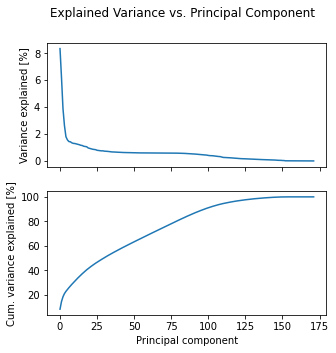

In [44]:
# - Running the function
plot_explained_var_ratio(pca)

> **Notes:** The first principal component explains around 8% of the total variance. The explained variance ratio drops quickly to 1–2% level. It means that the data doesn't have only a few components that explain the data, but it's more widely distributed. The cumulative curve is almost linear between 25 and 100 principal components and completely flat after around component 150 (at 100%).

In [45]:
# - Defining a cumulative cutoff function for principal components
def calc_PCA_cutoff(pca, cum_threshold = 0.99):
    """
    Calculates a cutoff principal component (PCA) for a given cumulative threshold value
    for explained variance ratio.

    Args:
        (pca object) pca - PCA object
        (float) cum_threshold - cumulative threshold value
    Returns:
        (list) cutoff_component - nth PCA principal component

    """

    pca_explained_var_ratio = pca.explained_variance_ratio_
    cutoff_component = None

    for idx in range(len(pca_explained_var_ratio.cumsum())):
        cumsum_rounded = round(pca_explained_var_ratio.cumsum()[idx], 3)

        if cumsum_rounded >= cum_threshold:
            print('First {} principal components explained total variance by {}%'
                  .format(idx + 1, 100 * cum_threshold))
            cutoff_component = idx + 1
            break

    if cumsum_rounded < cum_threshold:
        print('ERROR: Principal components can explain only {}% of total variance.' \
              .format(100 * cumsum_rounded))

    return cutoff_component

In [46]:
# Find the cut-off principal component (threshold value 95-99% suggested)
# Source: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components

n_PCA_components = calc_PCA_cutoff(pca, 0.99)

First 137 principal components explained total variance by 99.0%


> **Notes:** By using PCA we can reduce the features by 20% (from 172 to 137) while having 99% explained variance to avoid data loss.

In [47]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=n_PCA_components) # or we could use the threshold value 0.99
azdias_pca = pca.fit_transform(azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

The first principal component explains around 8% of the total variance and the explained variance ratio drops quickly to 1–2% level. The cumulative explained variance curve reaches 99% level at component 137 which was chosen as the cut-off value. By using the PCA method we could reduce the features by 20% (from 172 to 137) and still avoid data loss. We can expect that the last principal components (almost zero explained variance ratio) have less contribution to the results.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [48]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# - Defining a function for PCA weight output
def pca_weight_list(data_df, pca, component):
    """
    Prints list weights for a given principal component (PCA) combined
    with original features in demographics data

    Args:
        (dframe) data - demographics data dataframe (for feature names)
        (pca object) pca - PCA object
        (integer) component - principal component
    Returns:
        (dframe) pc_weights - weights with original features

    """
    
    pc_weights = pd.Series(pca.components_[component-1], index=data_df.columns) \
                           .sort_values(ascending=False)
    
    return pc_weights

In [49]:
# Call funcion using last DataFrame as column headers
pca_weight_list(azdias_cleaned, pca, 1)

LP_STATUS_GROB_1.0        0.195766
CAMEO_INTL_2015_WEALTH    0.191815
PLZ8_ANTG3                0.189964
HH_EINKOMMEN_SCORE        0.187165
PLZ8_ANTG4                0.185199
                            ...   
KBA05_GBZ                -0.186267
PLZ8_ANTG1               -0.191490
FINANZ_MINIMALIST        -0.195379
KBA05_ANTG1              -0.196139
MOBI_REGIO               -0.209958
Length: 172, dtype: float64

> **Notes:** Top-3 positive weights: social status (low-income earners), wealth stage (ORDINAL), and 6-10 family houses in macro-cell (ORDINAL); Top-3 negative weights: movement patterns (ORDINAL), 1-2 family houses in micro-cell (ORDINAL), and low-financial interest (ORDINAL).

> **Notes:** The first principal component focuses on the financial status and the neighborhood.

In [50]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_list(azdias_cleaned, pca, 2)

ALTERSKATEGORIE_GROB            0.234998
FINANZ_VORSORGER                0.219954
ZABEOTYP_3.0                    0.204867
SEMIO_ERL                       0.189179
SEMIO_LUST                      0.166488
                                  ...   
SEMIO_TRADV                    -0.211124
FINANZ_UNAUFFAELLIGER          -0.216656
SEMIO_REL                      -0.219399
FINANZ_SPARER                  -0.224407
PRAEGENDE_JUGENDJAHRE_DECADE   -0.238428
Length: 172, dtype: float64

> **Notes:** Top-3 positive weights: estimated age (ORDINAL), financially prepared (ORDINAL), and energy consumption (smart); Top-3 negative weights: dominating movement in person's youth (ORDINAL), financially money-saver (ORDINAL), and religious personality (ORDINAL).

> **Notes:** This principal component focuses on values and habits about how they spend money and the component is also related to age.

In [51]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_list(azdias_cleaned, pca, 3)

SEMIO_VERT       0.325047
SEMIO_FAM        0.257635
SEMIO_SOZ        0.257510
SEMIO_KULT       0.246939
FINANZTYP_5.0    0.137317
                   ...   
SEMIO_ERL       -0.200464
SEMIO_KRIT      -0.270533
SEMIO_DOM       -0.294604
SEMIO_KAEM      -0.323512
ANREDE_KZ       -0.351054
Length: 172, dtype: float64

> **Notes:** Top-3 positive weights: dreamful personality (ORDINAL), family-minded personality (ORDINAL), and socially-minded personality (ORDINAL); Top-3 negative weights: gender (BINARY), combative attitude personality (ORDINAL), and dominant-minded personality (ORDINAL).

> **Notes:** This principal component focuses on gender and personal qualities (dreaming, family-minded, dominant, etc.).

### Discussion 2.3: Interpret Principal Components

The first principal components (PC) have explained variance ratios 8.3%, 6.2%, and 3.9% (explain roughly 18% of all variance in PCA). I extracted their three largest positive and negative feature weights. We can estimate what aspect of the data the PC is covering. The sign of the weight explains to which direction the weight affects, but not the actual value (which may be in "low" or "high", or in other words negative or positive). That's why I'm just making general notes on what the group of weights can mean since they are correlated with each other. I have used sources like [URL](https://www.theanalysisfactor.com/principal-component-analysis-negative-loadings/) to understand the meaning of weights.

The first PC focuses on both the financial status and the neighborhood which are connected (poor vs. wealthy). The second PC focuses on values and habits about how people spend money and is also related to age (money-saver vs. spender). The third PC focuses on gender and is connected to personality aspects (dreaming, social, dominant), etc. I presume the third PC holds aspects of traditional lifestyle vs. high risk-taking.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [52]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

# - Defining elbow curve calculation as a function
def calculate_elbow_curve(input_data, max_clusters):
    """
    Plots so-called elbow curve by calculating k-Means with increasing k

    Args:
        (numpy) input_data - input data
        (int) max_clusters - maximum number of calculated clusters
    """

    centers = [*range(1,max_clusters+1)]
    average_distance = []

    for k in centers:
        # Fit a kmeans model with changing k
        kmeans = KMeans(n_clusters=k, n_init=10)
        model = kmeans.fit(input_data)
    
        # Calculate average distance from each point to assigned cluster center
        transforms = model.transform(input_data) # provides distances to cluster centers
        labels = model.labels_ # provides labels for each point
        distances = np.zeros(len(labels))

        for index in range(len(labels+1)):
            distances[index] = transforms[index][labels[index]]
        average_distance.append(distances.mean())

        # Print calculation progress
        print(f'Calculated K-Means for k={k:>2} (avg. distance {distances.mean():.2f})')
        
    # Plot elbow curve
    plt.plot(centers, average_distance, linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('Average distance to cluster centroid');
    plt.title('Average distance vs. K');

Calculated K-Means for k= 1 (avg. distance 12.81)
Calculated K-Means for k= 2 (avg. distance 12.37)
Calculated K-Means for k= 3 (avg. distance 12.15)
Calculated K-Means for k= 4 (avg. distance 12.01)
Calculated K-Means for k= 5 (avg. distance 11.92)
Calculated K-Means for k= 6 (avg. distance 11.84)
Calculated K-Means for k= 7 (avg. distance 11.76)
Calculated K-Means for k= 8 (avg. distance 11.71)
Calculated K-Means for k= 9 (avg. distance 11.66)
Calculated K-Means for k=10 (avg. distance 11.62)
Calculated K-Means for k=11 (avg. distance 11.57)
Calculated K-Means for k=12 (avg. distance 11.54)
Calculated K-Means for k=13 (avg. distance 11.48)
Calculated K-Means for k=14 (avg. distance 11.46)
Calculated K-Means for k=15 (avg. distance 11.41)
Calculated K-Means for k=16 (avg. distance 11.37)
Calculated K-Means for k=17 (avg. distance 11.32)
Calculated K-Means for k=18 (avg. distance 11.29)
Calculated K-Means for k=19 (avg. distance 11.24)
Calculated K-Means for k=20 (avg. distance 11.21)


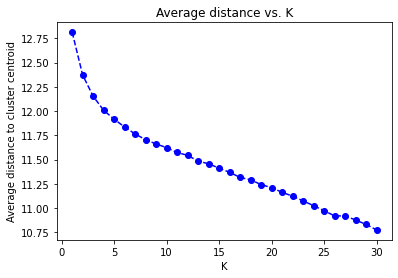

In [53]:
# - Calculate elbow curve
calculate_elbow_curve(azdias_pca, 30)

> **Notes:** The elbow is located at 5–7 clusters. I chose 7 clusters that also seem to produce quite an even distribution for the general demographics.

> **Notes:** I used the default value for n_init which means the algorithm ran 10 times with different centroid seeds and returns the best output. In the re-run, I'm using a higher value since the cluster point distributions changed between the runs.

In [54]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=7, n_init=50)
azdias_kmeans = kmeans.fit(azdias_pca)
azdias_pred = kmeans.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

I chose to use seven clusters based on the elbow curve calculation. It also seemed to produce quite an even data point distribution for the general demographics. Though, we don't presume the general demographics have such evenly distributed segments.

I noticed that the K-Means algorithm was sensitive to the number of different centroid seeds and the cluster point distributions looked different. That's why I increased the different centroid seeds from the default value.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [55]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [56]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Clean data by assuming (and also verified) similar missing data as in general demographics
# - Same 34% threshold value for features and 32 missing values for rows
customers_cleaned = clean_data(customers, feat_info, 34, 32, 'low')

# Adding one missing feature to dataset
customers_cleaned['GEBAEUDETYP_5.0']=0

customers_imp = imp.transform(customers_cleaned)
customers_scaled = scaler.transform(customers_imp)
customers_pca = pca.transform(customers_scaled)
customers_pred = kmeans.predict(customers_pca)

Input demographics data:
- Number of features: 85
- Number of rows: 191,652

Process:
- Converted missing values to empty values (NaN)
- Removed 6 features having over 34.00% missing values:
- Removed 49,881 rows having more than 32 missing values
- Converted non-numeric binary features to numeric
- Added one-hot encoding to multi-level category features
- Removed/engineered mix-type features

Output demographics data:
- Number of features: 171
- Number of rows: 141,771


> **Notes:** I added the GEBAEUDETYP_5.0 feature with 0 values since the customer dataset didn't have any values for the type. And there was only one occurrence in the general demographics dataset.

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

### Analyzing main data (low missing values)

In [57]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# - Function to count points in each cluster
def calc_cluster_distribution(array):
    """
    Calculates proportional count of points in each cluster

    Args:
        (numpy) array - output vector from k-means prediction
    Returns:
        (numpy) cluster_distribution - proportional count of points in each cluster

    """

    # Number of clusters
    n_clusters = array.max() + 1
    n_count = len(array)

    cluster_distribution = np.zeros(n_clusters)
    for cluster in range(n_clusters):
        cluster_distribution[cluster] = np.sum(array==cluster)

    # Divide by total points
    cluster_distribution = cluster_distribution / n_count

    return cluster_distribution

In [58]:
# Defining functions to analyze cluster data

# - Calculate cluster center in original data
def inverse_cluster_center(cluster_id, kmeans, pca, scaler):
    """
    Calculates a reconstruction of cluster center in original demographics
    label values

    Args:
        (int) cluster_id - cluster ID from k-Means results (in 1...n)
        (kmeans object) kmeans - k-Means object
        (pca object) pca - PCA object
        (scaler object) scaler - scaler object
    Returns:
        (numpy vector) cluster_center_normal - reconstructed values at cluster center
    """

    # Get the cluster center in principal components in PCA dimensions
    cluster_center_pca = kmeans.cluster_centers_[cluster_id - 1]
    # Get the cluster center reconstruction in scaled values
    cluster_center_scaled = pca.inverse_transform(cluster_center_pca)
    # Get the cluster center reconstruction in original values
    cluster_center_normal = scaler.inverse_transform(cluster_center_scaled)

    return cluster_center_normal

# - Calculate reconstructed features using first principal components
def print_reconstructed_features(cluster_id, kmeans, pca, scaler, data_df):
    """
    Cleans "df" by converting missing values, removing missing data based on given
    threshold values, and does some re-encoding and engineering.

    Args:
        (int) cluster_id - cluster ID from k-Means results (in 1...n)
        (kmeans object) kmeans - k-Means object
        (pca object) pca - PCA object
        (scaler object) scaler - scaler object
        (dframe) data_df - demograpics dataframe (for headers)
    """
    
    # Number of PC components shown
    n_components = 3
    
    # Calculate cluster center
    cluster_center = inverse_cluster_center(cluster_id, kmeans, pca, scaler)
    cluster_center_df = pd.Series(cluster_center, index=data_df.columns) \
                        .sort_values(ascending=False)

    # Making es
    print('Filtering original features based on PC weights\n')
    for component in range(1, n_components+1):

        print(f'Three largest weights in PCA component {component}:')
        
        # Absolute values should work here since looking for strongest correlation
        weights = pca_weight_list(data_df, pca, component).abs() \
                  .sort_values(ascending=False)

        for idx, value in weights.head(3).items():
            print(f'- Feature {idx}', end=' ')
            print('with inversed center label: {} ({:.2f})' \
                  .format(cluster_center_df.loc[idx].round(), cluster_center_df.loc[idx]))

> **Notes:** I am using the first three PCs to select features in the original dataset. There could be better methods to calculate the features that are important or represent better each cluster. The first PCs explain better the whole data and it's easier to compare the results from different clusters. On the other hand, the differences may not be as clear.

[Text(0.5, 0, 'Cluster ID')]

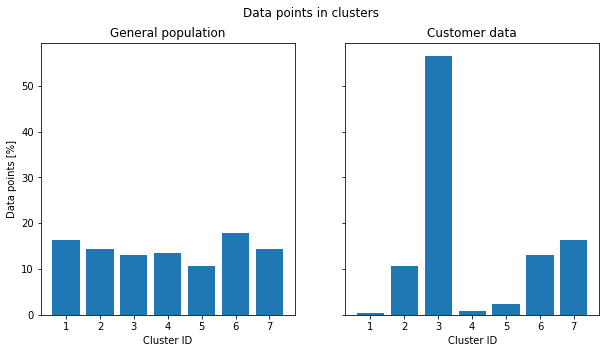

In [59]:
# Subplots for proportional data points in clusters

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
fig.suptitle('Data points in clusters')

azdias_cluster_percentages = 100 * calc_cluster_distribution(azdias_pred)
customers_cluster_percentages = 100 * calc_cluster_distribution(customers_pred)
cluster_x_axis = [*range(1, len(azdias_cluster_percentages)+1)]

axes[0].bar(cluster_x_axis, azdias_cluster_percentages)
axes[1].bar(cluster_x_axis, customers_cluster_percentages)

axes[0].set_title('General population')
axes[1].set_title('Customer data')

axes[0].set(xlabel='Cluster ID', ylabel='Data points [%]')
axes[1].set(xlabel='Cluster ID')

> **Notes:** The general demographics clusters have quite an even distribution of data points. However, the customer demographics have one cluster that has almost 60% of data points and three clusters that have only a few percent of data points.

> **NOTES: The cluster IDs can change between runs, so the cluster_id needs to be checked after re-runs. I didn't automate it yet.**

In [60]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_id = 3
print_reconstructed_features(cluster_id, kmeans, pca, scaler, azdias_cleaned)

Filtering original features based on PC weights

Three largest weights in PCA component 1:
- Feature MOBI_REGIO with inversed center label: 4.0 (4.21)
- Feature KBA05_ANTG1 with inversed center label: 3.0 (2.81)
- Feature LP_STATUS_GROB_1.0 with inversed center label: 0.0 (0.00)
Three largest weights in PCA component 2:
- Feature PRAEGENDE_JUGENDJAHRE_DECADE with inversed center label: 4.0 (3.57)
- Feature ALTERSKATEGORIE_GROB with inversed center label: 3.0 (3.37)
- Feature FINANZ_SPARER with inversed center label: 2.0 (1.61)
Three largest weights in PCA component 3:
- Feature ANREDE_KZ with inversed center label: 1.0 (1.50)
- Feature SEMIO_VERT with inversed center label: 5.0 (4.70)
- Feature SEMIO_KAEM with inversed center label: 4.0 (4.22)


| Feature                      | Label | Meaning |
| ---                          | ---   | --- |
| MOBI_REGIO                   | 4     | Movement pattern: low movement |
| KBA05_ANTG1                  | 3     | Number of 1-2 family houses in micro-cell: high share |
| LP_STATUS_GROB_1.0           | 0     | Social status (low-income earners): no |
| PRAEGENDE_JUGENDJAHRE_DECADE | 4     | Dominant movement in person's youth (decade): 70s |
| ALTERSKATEGORIE_GROB         | 3     | Age estimation: 46-60 years old |
| FINANZ_SPARER                | 2     | Financial minimalists: high |
| ANREDE_KZ                    | 1.5   | Gender: male (1) / female (2) |
| SEMIO_VERT                   | 5     | Dreamful personality: low affinity |
| SEMIO_KAEM                   | 4     | Combative attitude: average |

> **Notes:** Males/females 46–60 years old who live in a neighborhood of 1-2 family homes and don't move often. They aren't low-income earners and likely financial minimalists. They don't have a dreamful personality and are average in combative attitude.

In [61]:
cluster_id = 1
print_reconstructed_features(cluster_id, kmeans, pca, scaler, azdias_cleaned)

Filtering original features based on PC weights

Three largest weights in PCA component 1:
- Feature MOBI_REGIO with inversed center label: 2.0 (1.64)
- Feature KBA05_ANTG1 with inversed center label: 0.0 (0.31)
- Feature LP_STATUS_GROB_1.0 with inversed center label: 1.0 (0.92)
Three largest weights in PCA component 2:
- Feature PRAEGENDE_JUGENDJAHRE_DECADE with inversed center label: 6.0 (5.60)
- Feature ALTERSKATEGORIE_GROB with inversed center label: 2.0 (1.86)
- Feature FINANZ_SPARER with inversed center label: 4.0 (4.46)
Three largest weights in PCA component 3:
- Feature ANREDE_KZ with inversed center label: 2.0 (1.58)
- Feature SEMIO_VERT with inversed center label: 4.0 (3.74)
- Feature SEMIO_KAEM with inversed center label: 5.0 (4.72)


| Feature                      | Label | Meaning |
| ---                          | ---   | --- |
| MOBI_REGIO                   | 2     | Movement pattern: high movement |
| KBA05_ANTG1                  | 0     | Number of 1-2 family houses in micro-cell: no 1-2 family homes |
| LP_STATUS_GROB_1.0           | 1     | Social status (low-income earners): yes |
| PRAEGENDE_JUGENDJAHRE_DECADE | 6     | Dominant movement in person's youth (decade): 90s |
| ALTERSKATEGORIE_GROB         | 2     | Age estimation: 30-45 years old |
| FINANZ_SPARER                | 4     | Financial minimalists: low |
| ANREDE_KZ                    | 1.5   | Gender: male (1) / female (2) |
| SEMIO_VERT                   | 4     | Dreamful personality: average affinity |
| SEMIO_KAEM                   | 5     | Combative attitude: low affinity |

> **Notes:** Males/females 30–45 years old who live in a neighborhood of no 1–2 family homes and move often. They are low-income earners and not likely financial minimalists. They are average on the dreamful personality scale and have a low combative attitude.

In [81]:
cluster_id = 4
print_reconstructed_features(cluster_id, kmeans, pca, scaler, azdias_cleaned)

Filtering original features based on PC weights

Three largest weights in PCA component 1:
- Feature MOBI_REGIO with inversed center label: 4.0 (3.60)
- Feature KBA05_ANTG1 with inversed center label: 2.0 (2.05)
- Feature LP_STATUS_GROB_1.0 with inversed center label: 0.0 (0.28)
Three largest weights in PCA component 2:
- Feature PRAEGENDE_JUGENDJAHRE_DECADE with inversed center label: 6.0 (5.54)
- Feature ALTERSKATEGORIE_GROB with inversed center label: 2.0 (1.97)
- Feature FINANZ_SPARER with inversed center label: 4.0 (3.95)
Three largest weights in PCA component 3:
- Feature ANREDE_KZ with inversed center label: 2.0 (1.97)
- Feature SEMIO_VERT with inversed center label: 3.0 (2.57)
- Feature SEMIO_KAEM with inversed center label: 6.0 (5.55)


| Feature                      | Label | Meaning |
| ---                          | ---   | --- |
| MOBI_REGIO                   | 4     | Movement pattern: low movement |
| KBA05_ANTG1                  | 2     | Number of 1-2 family houses in micro-cell: average share |
| FINANZ_MINIMALIST            | 0     | Social status (low-income earners): no |
| PRAEGENDE_JUGENDJAHRE_DECADE | 6     | Dominant movement in person's youth (decade): 90s |
| ALTERSKATEGORIE_GROB         | 2     | Age estimation: 30-45 years old |
| FINANZ_SPARER                | 4     | Financial minimalists: low |
| ANREDE_KZ                    | 2     | Gender: female |
| SEMIO_VERT                   | 3     | Dreamful personality: high affinity |
| SEMIO_KAEM                   | 6     | Combative attitude: very low affinity |

> **Notes:** Females 30–45 years old who live in a neighborhood of an average share of 1–2 family homes and don't move often. They aren't low-income earners and are not likely financial minimalists. They have a dreamful personality but a low combative attitude.

In [82]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_id = 5
print_reconstructed_features(cluster_id, kmeans, pca, scaler, azdias_cleaned)

Filtering original features based on PC weights

Three largest weights in PCA component 1:
- Feature MOBI_REGIO with inversed center label: 4.0 (3.59)
- Feature KBA05_ANTG1 with inversed center label: 2.0 (2.06)
- Feature LP_STATUS_GROB_1.0 with inversed center label: 0.0 (0.19)
Three largest weights in PCA component 2:
- Feature PRAEGENDE_JUGENDJAHRE_DECADE with inversed center label: 6.0 (5.62)
- Feature ALTERSKATEGORIE_GROB with inversed center label: 2.0 (1.94)
- Feature FINANZ_SPARER with inversed center label: 4.0 (3.90)
Three largest weights in PCA component 3:
- Feature ANREDE_KZ with inversed center label: 1.0 (1.00)
- Feature SEMIO_VERT with inversed center label: 6.0 (6.27)
- Feature SEMIO_KAEM with inversed center label: 2.0 (2.21)


| Feature                      | Label | Meaning |
| ---                          | ---   | --- |
| MOBI_REGIO                   | 4     | Movement pattern: low movement |
| KBA05_ANTG1                  | 2     | Number of 1-2 family houses in micro-cell: average share |
| LP_STATUS_GROB_1.0           | 0     | Social status (low-income earners): no |
| PRAEGENDE_JUGENDJAHRE_DECADE | 6     | Dominant movement in person's youth (decade): 90s |
| ALTERSKATEGORIE_GROB         | 2     | Age estimation: 30–45 years old |
| FINANZ_SPARER                | 4     | Financial minimalists: low |
| ANREDE_KZ                    | 1     | Gender: male |
| SEMIO_VERT                   | 6     | Dreamful personality: very low affinity |
| SEMIO_KAEM                   | 2     | Combative attitude: very high affinity |

> **Notes:** Males 30–45 years old who live in a neighborhood of average share of 1–2 family homes and don't move often. They aren't low-income earners and are not likely financial minimalists. They don't have a dreamful personality and have a very high combative attitude.

### Analyzing subset with high number of missing values

> **Notes:** This subset consists of around 10% of rows in the general demographics and around 26% of the customer demographics data.

In [64]:
# Cleaning general demographics data
azdias_cleaned2 = clean_data(azdias, feat_info, 34, 32, 'high')

Input demographics data:
- Number of features: 85
- Number of rows: 891,221

Process:
- Converted missing values to empty values (NaN)
- Removed 6 features having over 34.00% missing values:
- Removed 798,276 rows having equal or less than 32 missing values
- Converted non-numeric binary features to numeric
- Added one-hot encoding to multi-level category features
- Removed/engineered mix-type features

Output demographics data:
- Number of features: 115
- Number of rows: 92,945


Text(0, 0.5, 'Count of features')

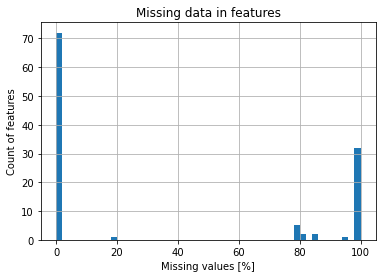

In [65]:
# Plot histogram of missing values on features after cleaning
nan_feat_percent2 = (100 * azdias_cleaned2.isnull().sum() / azdias_cleaned2.shape[0]).sort_values(axis=0, ascending=False)
axes = nan_feat_percent2.hist(bins=50)
axes.set_title("Missing data in features")
axes.set_xlabel("Missing values [%]")
axes.set_ylabel("Count of features")

In [66]:
nan_feat_percent_threshold2 = 75
nan_feat_outliers2 = nan_feat_percent2[nan_feat_percent2 > nan_feat_percent_threshold2]
azdias_cleaned2.drop(columns=nan_feat_outliers2.index.tolist(), inplace=True)

print('Removed outlier features (values in %):')
print(nan_feat_outliers2.to_string())

Removed outlier features (values in %):
PLZ8_ANTG4                        100.000000
REGIOTYP                          100.000000
KBA05_ANTG1                       100.000000
KBA05_ANTG2                       100.000000
KBA05_ANTG3                       100.000000
KBA05_ANTG4                       100.000000
KBA05_GBZ                         100.000000
KKK                               100.000000
MOBI_REGIO                        100.000000
KBA13_ANZAHL_PKW                  100.000000
CAMEO_DEUG_2015                   100.000000
PLZ8_ANTG1                        100.000000
PLZ8_ANTG2                        100.000000
PLZ8_ANTG3                        100.000000
PLZ8_BAUMAX_MAINLY_FAMILYHOMES    100.000000
PLZ8_HHZ                          100.000000
PLZ8_GBZ                          100.000000
CAMEO_INTL_2015_WEALTH            100.000000
CAMEO_DEU_2015                    100.000000
CAMEO_INTL_2015_LIFESTAGE         100.000000
ORTSGR_KLS9                        99.997848
BALLRAUM       

> **Notes:** Making a note that after cleaning the subset, there were fewer features than the main data. Also, there were around 30 features that had over 75% missing values (and half of them missing all values). Those features were removed before the imputation.

In [67]:
# Run imputer, standard scaler and PCA

print(f'Missing values before imputer: {azdias_cleaned2.isnull().sum().sum():,}')
imp2 = SimpleImputer(strategy='mean') # Replace with "Imputer" in old sklean version
azdias_imp2 = imp2.fit_transform(azdias_cleaned2)
print(f'Missing values after imputer: {np.isnan(azdias_imp2).sum().sum()}')

scaler2 = StandardScaler()
azdias_scaled2 = scaler2.fit_transform(azdias_imp2)

pca2 = PCA()
azdias_pca2 = pca2.fit_transform(azdias_scaled2)

Missing values before imputer: 18,630
Missing values after imputer: 0


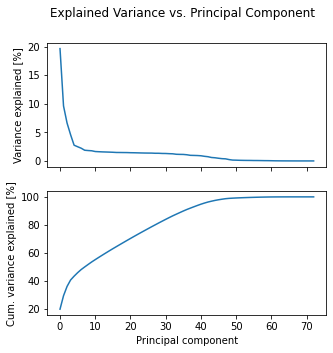

In [68]:
# Plot explained variance ratio
plot_explained_var_ratio(pca2)

In [70]:
# Calculate cut-off component (using same 99% value as for main dataset)
n_PCA_components2 = calc_PCA_cutoff(pca2, 0.99)

First 50 principal components explained total variance by 99.0%


> **Notes:** By using PCA we can reduce the features by 32% (from 73 to 50) while having 99% explained variance to avoid data loss.

In [71]:
# Re-run PCA and transform data
pca2 = PCA(n_components=n_PCA_components2) # or we could use the threshold value 0.99
azdias_pca2 = pca2.fit_transform(azdias_scaled2)

#### Checking the weights of the first three principal components (PCA)

In [72]:
pca_weight_list(azdias_cleaned2, pca2, 1)

SEMIO_VERT               0.246821
NATIONALITAET_KZ_1.0     0.231735
FINANZ_MINIMALIST        0.210021
SHOPPER_TYP_1.0          0.170489
FINANZTYP_3.0            0.160107
                           ...   
FINANZ_ANLEGER          -0.215555
FINANZ_UNAUFFAELLIGER   -0.216604
SEMIO_PFLICHT           -0.218700
SEMIO_REL               -0.220987
FINANZTYP_4.0           -0.247040
Length: 73, dtype: float64

> **Notes**: Top-3 positive weights: dreamful personality (ORDINAL), nationality based on given name (German-sounding), and financial minimalists (ORDINAL); Top-3 negative weights: financial type (prepared), religious personality (ORDINAL), and dutiful personality (ORDINAL).

In [73]:
pca_weight_list(azdias_cleaned2, pca2, 2)

SEMIO_KULT          0.304108
SEMIO_TRADV         0.275285
SEMIO_FAM           0.237271
SEMIO_MAT           0.219996
FINANZ_SPARER       0.202414
                      ...   
SEMIO_KRIT         -0.180951
FINANZTYP_2.0      -0.201582
ZABEOTYP_3.0       -0.206850
FINANZ_VORSORGER   -0.242136
SEMIO_ERL          -0.243049
Length: 73, dtype: float64

> **Notes:** Top-3 positive weights: cultural-minded personality (ORDINAL), traditional-minded personality (ORDINAL), and family-minded personality (ORDINAL); Top-3 negative weights: event-oriented personality (ORDINAL), financially prepared (ORDINAL), and energy consumption (fair supplied).

In [74]:
pca_weight_list(azdias_cleaned2, pca2, 3)

SEMIO_KAEM           0.285489
SEMIO_RAT            0.281966
SEMIO_ERL            0.224329
SEMIO_KRIT           0.207495
SEMIO_DOM            0.204960
                       ...   
SEMIO_LUST          -0.161505
FINANZ_MINIMALIST   -0.163621
SEMIO_KULT          -0.218305
SEMIO_MAT           -0.220770
SEMIO_FAM           -0.238469
Length: 73, dtype: float64

> **Notes:** Top-3 positive weights: combative personality (ORDINAL), rational personality (ORDINAL), and event-oriented personality (ORDINAL); Top-3 negative weights: family-oriented personality (ORDINAL), materialistic personality (ORDINAL), and culture-minded personality.

> **Notes:** The subset doesn't have as clear explanations for PCA component weights. The first component has financial aspects, personal value qualities (dreamful, religious, dutiful), and also nationality. The second component has mostly personal qualities (cultural-minded, traditional-minded, family-minded, event-oriented). The third component has similar qualities as the second component, but additionally rationality, combative and materialistic aspects.

Calculated K-Means for k= 1 (avg. distance 6.92)
Calculated K-Means for k= 2 (avg. distance 6.06)
Calculated K-Means for k= 3 (avg. distance 5.84)
Calculated K-Means for k= 4 (avg. distance 5.32)
Calculated K-Means for k= 5 (avg. distance 5.17)
Calculated K-Means for k= 6 (avg. distance 5.07)
Calculated K-Means for k= 7 (avg. distance 5.04)
Calculated K-Means for k= 8 (avg. distance 4.95)
Calculated K-Means for k= 9 (avg. distance 4.88)
Calculated K-Means for k=10 (avg. distance 4.84)
Calculated K-Means for k=11 (avg. distance 4.80)
Calculated K-Means for k=12 (avg. distance 4.77)
Calculated K-Means for k=13 (avg. distance 4.52)
Calculated K-Means for k=14 (avg. distance 4.51)
Calculated K-Means for k=15 (avg. distance 4.68)
Calculated K-Means for k=16 (avg. distance 4.44)
Calculated K-Means for k=17 (avg. distance 4.42)
Calculated K-Means for k=18 (avg. distance 4.59)
Calculated K-Means for k=19 (avg. distance 4.50)
Calculated K-Means for k=20 (avg. distance 4.48)
Calculated K-Means f

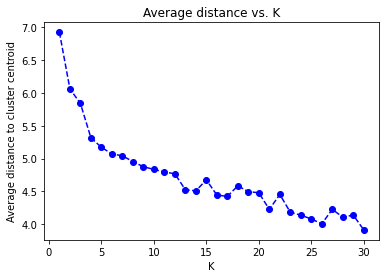

In [75]:
# Calculate the elbow curve
calculate_elbow_curve(azdias_pca2, 30)

> **Notes:** The elbow ends earlier (5–6 clusters) than with the main dataset. I chose 5 clusters for this smaller dataset.

In [76]:
# Re-fit the K-Means and make prediction
kmeans2 = KMeans(n_clusters=5, n_init=50)
azdias_kmeans2 = kmeans2.fit(azdias_pca2)
azdias_pred2 = kmeans2.predict(azdias_pca2)

#### Process customer demographics data

In [77]:
# Clean customer data assuming similar missing data as in general demographics
customers_cleaned2 = clean_data(customers, feat_info, 34, 32, 'high')
customers_cleaned2.drop(columns=nan_feat_outliers2.index.tolist(), inplace=True) # remove same columns age in general demographics

print('\nRemoved outlier features (values in %):')
print(nan_feat_outliers2.to_string())

# Run imputer, standard scaler, PCA and make K-Means prediction
customers_imp2 = imp2.transform(customers_cleaned2)
customers_scaled2 = scaler2.transform(customers_imp2)
customers_pca2 = pca2.transform(customers_scaled2)
customers_pred2 = kmeans2.predict(customers_pca2)

Input demographics data:
- Number of features: 85
- Number of rows: 191,652

Process:
- Converted missing values to empty values (NaN)
- Removed 6 features having over 34.00% missing values:
- Removed 141,771 rows having equal or less than 32 missing values
- Converted non-numeric binary features to numeric
- Added one-hot encoding to multi-level category features
- Removed/engineered mix-type features

Output demographics data:
- Number of features: 115
- Number of rows: 49,881

Removed outlier features (values in %):
PLZ8_ANTG4                        100.000000
REGIOTYP                          100.000000
KBA05_ANTG1                       100.000000
KBA05_ANTG2                       100.000000
KBA05_ANTG3                       100.000000
KBA05_ANTG4                       100.000000
KBA05_GBZ                         100.000000
KKK                               100.000000
MOBI_REGIO                        100.000000
KBA13_ANZAHL_PKW                  100.000000
CAMEO_DEUG_2015          

 #### Examine cluster content

[Text(0.5, 0, 'Cluster ID')]

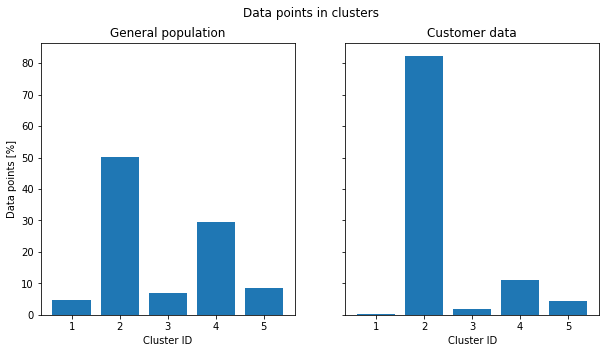

In [78]:
# Subplots for proportional data points in clusters
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10,5))
fig.suptitle('Data points in clusters')

azdias_cluster_percentages = 100 * calc_cluster_distribution(azdias_pred2)
customers_cluster_percentages = 100 * calc_cluster_distribution(customers_pred2)
cluster_x_axis = [*range(1, len(azdias_cluster_percentages)+1)]

axes[0].bar(cluster_x_axis, azdias_cluster_percentages)
axes[1].bar(cluster_x_axis, customers_cluster_percentages)

axes[0].set_title('General population')
axes[1].set_title('Customer data')

axes[0].set(xlabel='Cluster ID', ylabel='Data points [%]')
axes[1].set(xlabel='Cluster ID')

> **Notes:** The two distributions look quite similar compared to the differences in the main data. However, the customer demographics have one cluster that has around 80% of data points and one cluster is very small.

> **Notes: The cluster IDs can change between runs, so the cluster_id needs to be checked after re-runs. I didn't automate it yet**

In [83]:
# Cluster overpresented in customer data

cluster_id = 2
print_reconstructed_features(cluster_id, kmeans2, pca2, scaler2, azdias_cleaned2)

Filtering original features based on PC weights

Three largest weights in PCA component 1:
- Feature FINANZTYP_4.0 with inversed center label: 1.0 (1.00)
- Feature SEMIO_VERT with inversed center label: 1.0 (1.00)
- Feature NATIONALITAET_KZ_1.0 with inversed center label: 0.0 (0.00)
Three largest weights in PCA component 2:
- Feature SEMIO_KULT with inversed center label: 3.0 (3.00)
- Feature SEMIO_TRADV with inversed center label: 3.0 (3.00)
- Feature SEMIO_ERL with inversed center label: 3.0 (3.00)
Three largest weights in PCA component 3:
- Feature SEMIO_KAEM with inversed center label: 6.0 (6.00)
- Feature SEMIO_RAT with inversed center label: 4.0 (4.00)
- Feature SEMIO_FAM with inversed center label: 6.0 (6.00)


| Feature              | Label | Meaning |
| ---                  | ---   | --- |
| FINANZTYP_4.0        | 1     | Financial type (prepared): yes |
| SEMIO_VERT           | 1     | Personality (dreamful): highest affinity |
| NATIONALITAET_KZ_1.0 | 0     | Nationality based on given name (German-sounding): no |
| SEMIO_KULT           | 3     | Personality (cultural-minded): high affinity |
| SEMIO_TRADV          | 3     | Personality (traditional-minded): high affinity |
| SEMIO_ERL            | 3     | Personality (event-oriented): high affinity |
| SEMIO_KAEM           | 6     | Personality (combative attitude): very low affinity |
| SEMIO_RAT            | 4     | Personality (rational): average affinity |
| SEMIO_FAM            | 6     | Personality (family-minded): very low affinity |

In [84]:
# Cluster underpresented in customer data

cluster_id = 1
print_reconstructed_features(cluster_id, kmeans2, pca2, scaler2, azdias_cleaned2)

Filtering original features based on PC weights

Three largest weights in PCA component 1:
- Feature FINANZTYP_4.0 with inversed center label: 0.0 (0.14)
- Feature SEMIO_VERT with inversed center label: 3.0 (2.86)
- Feature NATIONALITAET_KZ_1.0 with inversed center label: 1.0 (0.70)
Three largest weights in PCA component 2:
- Feature SEMIO_KULT with inversed center label: 3.0 (2.78)
- Feature SEMIO_TRADV with inversed center label: 6.0 (5.87)
- Feature SEMIO_ERL with inversed center label: 5.0 (4.76)
Three largest weights in PCA component 3:
- Feature SEMIO_KAEM with inversed center label: 7.0 (6.57)
- Feature SEMIO_RAT with inversed center label: 6.0 (5.71)
- Feature SEMIO_FAM with inversed center label: 4.0 (4.12)


| Feature              | Label | Meaning |
| ---                  | ---   | --- |
| FINANZTYP_4.0        | 0     | Financial type (prepared): no |
| SEMIO_VERT           | 3     | Personality (dreamful): high affinity |
| NATIONALITAET_KZ_1.0 | 1     | Nationality based on given name (German-sounding): yes |
| SEMIO_KULT           | 3     | Personality (cultural-minded): high affinity |
| SEMIO_TRADV          | 6     | Personality (traditional-minded): very low affinity |
| SEMIO_ERL            | 5     | Personality (event-oriented): low affinity |
| SEMIO_KAEM           | 7     | Personality (combative attitude): lowest affinity |
| SEMIO_RAT            | 6     | Personality (rational): very low affinity |
| SEMIO_FAM            | 4     | Personality (family-minded): average affinity |

> **Notes:** People in the over-represented cluster are financially prepared and don't have a German-sounding given name. They are culture-minded, traditional-minded, and event-oriented, but not family-minded or have a combative attitude. They are average on the rationality scale.

> **Notes:** People in the under-represented cluster aren't financially prepared and have a German-sounding given name. They are culture-minded, but not traditional-minded or event-minded. They are average on the family-minded scale and unlikely rational-minded.

### Discussion 3.3: Compare Customer Data to Demographics Data

I divided the cleaned data into seven clusters. The general demographics data, the clusters had quite even distribution of data points. However, the customer demographics data had one cluster with almost 60% of data points and three clusters with only a few percent of data points.

I examined the over- and under-represented customer clusters by transforming the cluster centers back into the original feature values. Since there were almost two hundred features in the cleaned dataset, I filtered the features using principal components. I selected the three largest weights (prevailing features) from the first three principal components (PC). The first PCs explain better the whole data and it's easier to compare the results between the clusters. On the other hand, the differences may not be as clear.

The over-represented customer segment consists of males/females 46–60 years old who live in a neighborhood of 1–2 family homes and don't move often. They aren't low-income earners and likely financial minimalists. They don't have a dreamful personality and are average in combative attitude.

The under-represented segments are all 30–45 years old and not likely financial minimalists, but otherwise they have different qualities:

1. Low-income earner males/females who live in a neighborhood of no 1–2 family homes and move often. They are average on the dreamful personality scale and have a low combative attitude.
2. Not low-income earner females who live in a neighborhood of average share of 1–2 family homes and don't move often. They have a dreamful personality but a low combative attitude.
3. Not low-income earner males who live in a neighborhood of average share of 1–2 family homes and don't move often. They don't have a dreamful personality and have a very high combative attitude.

#### Subset with high number of missing data

I processed separately the subset that had more than 32 missing values of rows because the data looked different at the preprocessing stage. The subset consisted of around 10% (general demographics) and 26% (customer data) rows. Additional features had to be removed since had a high number of missing values (more than 75%). The missing values were imputed using the means of the features. Otherwise, the process was the same as with the main dataset.

The subset had only 73 features after cleaning (compared to 172 in main data). In the PCA step, I chose to use 50 principal components (reduced 32% of features). The principal components didn't have as clear explanations compared to the main data. The first component was a combination of financial aspects, personal values (dreamful, religious, dutiful), and nationality. The second component had mostly personal qualities (cultural-minded, traditional-minded, family-minded, event-oriented). The third component had similar qualities as the second component, but also rationality, combative and materialistic aspects.

I divided the subset data into five clusters. The general demographics data wasn't as evenly distributed among clusters. However, both subset demographics data had quite similar distributions compared. But the customer demographics had one cluster holding around 80% of data points and one very small cluster.

People in the over-represented customer segment are financially prepared and don't have a German-sounding given name. They are culture-minded, traditional-minded, and event-oriented, but not family-minded or have a combative attitude. They are average on the rationality scale. People in the under-represented customer segment aren't financially prepared and have a German-sounding given name. They are culture-minded, but not traditional-minded or event-minded. They are average on the family-minded scale and unlikely rational-minded.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.